In [480]:
import pandas as pd
from csv import writer
from tqdm import tqdm
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras import Model
from keras.layers import Input, LSTM, Conv1D, Conv2D, Reshape, Dense, BatchNormalization, Dropout, concatenate
from keras.callbacks import ModelCheckpoint
from model import build_model

In [671]:
WINDOW_SIZE = 20
OFFSET = 1
DIFFS = [4]

In [672]:
apcs = [f'ap_{i}' for i in range(10)]
avcs = [f'av_{i}' for i in range(10)]
bpcs = [f'bp_{i}' for i in range(10)]
bvcs = [f'bv_{i}' for i in range(10)]

keys = [x for ap, av, bp, bv in zip(apcs, avcs, bpcs, bvcs) for x in [ap, av, bp, bv]]
features = ['timestamp', 'bid_diff_feature_1', 'ask_diff_feature_1']
targets = [f'bid_diff_target_{i}' for i in DIFFS]

# Data

In [674]:
pd.set_option('max_rows', 100)

In [675]:
df = pd.read_csv('data.csv')
df

,timestamp,best_bid_price,best_ask_price,estimated_delivery_price,index_price,mark_price,open_interest,settlement_price,change_id,ap_0,...,bp_7,bv_7,ap_8,av_8,bp_8,bv_8,ap_9,av_9,bp_9,bv_9
0,1625848394814,33561.0,33561.5,33564.07,33564.07,33558.39,2890156196,32884.83,6096365586,33561.5,...,33551.0,10640.0,33589.5,19430.0,33550.0,10.0,33590.0,4540.0,33549.0,24720.0
1,1625848397615,33561.0,33561.5,33562.27,33562.27,33555.87,2890156196,32884.83,6096365722,33561.5,...,33551.0,10640.0,33587.0,1200.0,33550.0,10.0,33589.5,19430.0,33549.0,24720.0
2,1625848397963,33557.0,33557.5,33562.27,33562.27,33555.31,2890156186,32884.83,6096365846,33557.5,...,33548.5,500.0,33565.0,33560.0,33547.0,10.0,33566.0,18730.0,33546.5,20.0
3,1625848399819,33557.0,33557.5,33559.87,33559.87,33551.02,2890156186,32884.83,6096365981,33557.5,...,33548.5,500.0,33565.0,33560.0,33547.0,10.0,33566.0,18730.0,33546.5,20.0
4,1625848400900,33557.0,33557.5,33559.73,33559.73,33549.10,2890156186,32884.83,6096366013,33557.5,...,33548.5,500.0,33565.0,33560.0,33547.0,10.0,33566.0,18730.0,33546.5,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4641,1625854652036,33419.5,33420.0,33419.86,33419.86,33413.12,2890795596,32884.83,6096784105,33420.0,...,33409.0,22500.0,33427.5,7700.0,33408.5,7000.0,33428.5,100.0,33408.0,19380.0
4642,1625854653107,33410.0,33415.0,33418.55,33418.55,33412.15,2890795596,32884.83,6096784275,33415.0,...,33403.5,500.0,33423.5,5810.0,33403.0,10.0,33424.0,26190.0,33402.5,11760.0
4643,1625854654001,33408.5,33415.0,33418.55,33418.55,33412.20,2890795596,32884.83,6096784322,33415.0,...,33403.0,10.0,33423.5,5810.0,33402.5,11760.0,33424.0,26190.0,33402.0,55200.0
4644,1625854656038,33408.5,33415.0,33419.77,33419.77,33413.46,2890795596,32884.83,6096784374,33415.0,...,33403.0,10.0,33423.5,5810.0,33402.5,11760.0,33424.0,26190.0,33402.0,55200.0


In [676]:
def prepare_df(df):

    dfs = []

    for diff in DIFFS:
        dfs.append(-df[['best_bid_price', 'best_ask_price']].diff(-diff).rename(columns={'best_bid_price': f'bid_diff_target_{diff}', 'best_ask_price': f'ask_diff_target_{diff}'}))

    df0 = df[['timestamp', 'best_bid_price', 'best_ask_price']].diff(1).rename(columns={'best_bid_price': f'bid_diff_feature_{1}', 'best_ask_price': f'ask_diff_feature_{1}'})
    df0['timestamp'] /= 1000.

    df1 = df[['best_bid_price', 'best_ask_price'] + keys]
    dfX = pd.concat([df1, df0, *dfs], axis=1)

    # set prices as relative differences
    dfX[apcs] = dfX[apcs].sub(dfX['ap_0'], axis=0)
    dfX[bpcs] = -dfX[bpcs].sub(dfX['bp_0'], axis=0)

    # remove nans
    dfX = dfX[~dfX.isna().any(axis=1)]

    # rescale volumes
    l = 10.
    u = 1000000.
    dfX[avcs + bvcs] = (dfX[avcs + bvcs] - l) / (u - l)

    dfX = dfX.reset_index(drop=True)
    return dfX

dfX = prepare_df(df)
dfX[:20]

,best_bid_price,best_ask_price,ap_0,av_0,bp_0,bv_0,ap_1,av_1,bp_1,bv_1,...,bv_8,ap_9,av_9,bp_9,bv_9,timestamp,bid_diff_feature_1,ask_diff_feature_1,bid_diff_target_4,ask_diff_target_4
0,33561.0,33561.5,0.0,0.157542,-0.0,0.000000,2.0,0.001130,1.0,0.00001,...,0.000000,28.0,0.019420,12.0,0.02471,2.801,0.0,0.0,-4.0,-4.0
1,33557.0,33557.5,0.0,0.132311,-0.0,0.000000,2.5,0.039980,2.0,0.00001,...,0.000000,8.5,0.018720,10.5,0.00001,0.348,-4.0,-4.0,-3.5,4.0
2,33557.0,33557.5,0.0,0.132311,-0.0,0.000000,2.5,0.039980,2.0,0.00001,...,0.000000,8.5,0.018720,10.5,0.00001,1.856,0.0,0.0,-0.0,-0.0
3,33557.0,33557.5,0.0,0.132311,-0.0,0.000000,2.5,0.039980,2.0,0.00001,...,0.000000,8.5,0.018720,10.5,0.00001,1.081,0.0,0.0,-0.0,-0.0
4,33557.0,33557.5,0.0,0.132311,-0.0,0.000000,2.5,0.039980,2.0,0.00001,...,0.000000,8.5,0.018720,10.5,0.00001,0.921,0.0,0.0,-0.0,-0.0
5,33553.5,33561.5,0.0,0.004650,-0.0,0.003620,1.0,0.000120,0.5,0.00000,...,0.000030,19.5,0.003910,32.5,0.00334,1.001,-3.5,4.0,3.5,-4.0
6,33557.0,33557.5,0.0,0.163902,-0.0,0.000000,1.0,0.024990,2.0,0.00001,...,0.006160,7.0,0.016860,12.0,0.00003,0.139,3.5,-4.0,-0.0,-0.0
7,33557.0,33557.5,0.0,0.163902,-0.0,0.000000,1.0,0.024990,2.0,0.00001,...,0.006160,7.0,0.016860,12.0,0.00003,0.655,0.0,0.0,-0.0,-0.0
8,33557.0,33557.5,0.0,0.117411,-0.0,0.000000,1.5,0.021260,2.0,0.00001,...,0.006160,8.0,0.033560,12.0,0.01607,4.352,0.0,0.0,-0.0,-0.0
9,33557.0,33557.5,0.0,0.097481,-0.0,0.006870,2.0,0.000130,2.0,0.00001,...,0.006160,9.0,0.101721,11.0,0.00199,5.003,0.0,0.0,0.5,0.5


In [677]:
def split(df, offset, window_size):
    
    # X1
    X1 = np.array([df.iloc[i*offset:i*offset+window_size][keys] for i in range((len(df) - window_size) // offset)])
    X1 = X1[:, :, :, np.newaxis]
    
    # X2
    X2 = np.array([df.iloc[i*offset:i*offset+window_size][features] for i in range((len(df) - window_size) // offset)])
    
    # y
    y = dfX.iloc[offset-1+window_size:len(df):offset][targets].to_numpy()
    y = 0.5 * (y >= -3.) + 0.5 * (y >= 3.)

    return X1, X2, y

(array([ 888.,    0.,    0.,    0.,    0., 2856.,    0.,    0.,    0.,
         877.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

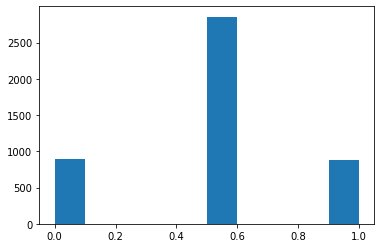

In [764]:
X1, X2, y = split(dfX, OFFSET, WINDOW_SIZE)
plt.hist(y)

In [765]:
X1_train, X1_test, X2_train, X2_test, y_train, y_test = train_test_split(X1, X2, y, test_size=0.15)

# Build model

In [766]:
def build_model(window_size, output_size):

    input_layer1 = Input(shape=(window_size, 40, 1))
    input_layer2 = Input(shape=(window_size, 3))

    x = Conv2D(10, kernel_size=(1, 2), strides=(1, 2), activation='relu')(input_layer1)
    x = Conv2D(10, kernel_size=(1, 2), strides=(1, 2), activation='relu')(x)
    x = Conv2D(10, kernel_size=(1, 10), activation='relu')(x)
    x = Reshape((window_size, -1))(x)

    x = concatenate([x, input_layer2])

    lstm_layer = LSTM(window_size)(x)
    bn_layer = BatchNormalization()(lstm_layer)
    dropout_layer = Dropout(0.2)(bn_layer)
    output_layer = Dense(output_size, activation='sigmoid')(dropout_layer)

    model = Model([input_layer1, input_layer2], output_layer)
    model.compile(optimizer='adam', loss='mse')

    return model


In [767]:
model = build_model(window_size=WINDOW_SIZE, output_size=len(DIFFS))
model.summary()

Model: "model_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_39 (InputLayer)           [(None, 20, 40, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_57 (Conv2D)              (None, 20, 20, 10)   30          input_39[0][0]                   
__________________________________________________________________________________________________
conv2d_58 (Conv2D)              (None, 20, 10, 10)   210         conv2d_57[0][0]                  
__________________________________________________________________________________________________
conv2d_59 (Conv2D)              (None, 20, 1, 10)    1010        conv2d_58[0][0]                  
___________________________________________________________________________________________

In [ ]:
cp_callback = ModelCheckpoint(filepath='_output/model.h5', save_weights_only=True, save_best_only=True)
history = model.fit([X1_train, X2_train], y_train, epochs=200, validation_split=0.15, callbacks=[cp_callback], verbose=2)

Epoch 1/200
105/105 - 5s - loss: 0.1250 - val_loss: 0.0972
Epoch 2/200
105/105 - 1s - loss: 0.1104 - val_loss: 0.0950
Epoch 3/200
105/105 - 1s - loss: 0.1010 - val_loss: 0.0936
Epoch 4/200
105/105 - 1s - loss: 0.0997 - val_loss: 0.0939
Epoch 5/200
105/105 - 1s - loss: 0.0979 - val_loss: 0.0897
Epoch 6/200
105/105 - 1s - loss: 0.0949 - val_loss: 0.0952
Epoch 7/200
105/105 - 1s - loss: 0.0942 - val_loss: 0.0909
Epoch 8/200
105/105 - 1s - loss: 0.0941 - val_loss: 0.0901
Epoch 9/200
105/105 - 1s - loss: 0.0918 - val_loss: 0.0889
Epoch 10/200
105/105 - 1s - loss: 0.0914 - val_loss: 0.0861
Epoch 11/200
105/105 - 1s - loss: 0.0909 - val_loss: 0.0919
Epoch 12/200
105/105 - 1s - loss: 0.0895 - val_loss: 0.0851
Epoch 13/200
105/105 - 1s - loss: 0.0887 - val_loss: 0.0863
Epoch 14/200
105/105 - 1s - loss: 0.0879 - val_loss: 0.0863
Epoch 15/200
105/105 - 1s - loss: 0.0868 - val_loss: 0.0886
Epoch 16/200
105/105 - 1s - loss: 0.0863 - val_loss: 0.0877
Epoch 17/200
105/105 - 1s - loss: 0.0867 - val_lo

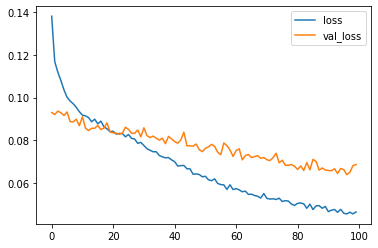

In [683]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

In [684]:
model.evaluate([X1_test, X2_test], y_test)

22/22 [==============================] - 0s 4ms/step - loss: 0.0708


0.07084748148918152

In [685]:
model.load_weights('_output/model.h5')

# Backtest

In [687]:
df2 = pd.read_csv('data2.csv')
df2

,timestamp,best_bid_price,best_ask_price,estimated_delivery_price,index_price,mark_price,open_interest,settlement_price,change_id,ap_0,...,bp_7,bv_7,ap_8,av_8,bp_8,bv_8,ap_9,av_9,bp_9,bv_9
0,1626042520635,34354.0,34390.0,34414.47,34414.47,34344.79,2889303196,33519.14,6104384614,34390.0,...,34030.0,140.0,34438.0,16050.0,33876.0,1000.0,34438.5,84250.0,33859.5,140.0
1,1626042520861,34354.0,34390.0,34414.47,34414.47,34344.79,2889303196,33519.14,6104384650,34390.0,...,34030.0,140.0,34438.0,16050.0,33876.0,1000.0,34438.5,84250.0,33859.5,140.0
2,1626042523606,34354.0,34390.0,34420.11,34420.11,34345.53,2889303196,33519.14,6104384695,34390.0,...,34030.0,140.0,34438.0,16050.0,33876.0,1000.0,34438.5,84250.0,33859.5,140.0
3,1626042525674,34354.0,34390.0,34417.25,34417.25,34339.59,2889303196,33519.14,6104384839,34390.0,...,34030.0,140.0,34441.0,2410.0,33876.0,1000.0,34442.5,103080.0,33859.5,140.0
4,1626042526602,34354.0,34390.0,34417.45,34417.45,34338.50,2889303196,33519.14,6104384865,34390.0,...,34030.0,140.0,34441.0,2410.0,33876.0,1000.0,34442.5,103080.0,33859.5,140.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
681,1626044219039,34394.0,34395.5,34387.16,34387.16,34392.45,2889302996,33519.14,6104446981,34395.5,...,34388.0,3500.0,34410.0,33060.0,34371.0,3440.0,34410.5,253040.0,34366.0,3040.0
682,1626044220669,34394.0,34395.5,34388.15,34388.15,34393.55,2889302996,33519.14,6104447115,34395.5,...,34366.0,3040.0,34410.5,166350.0,34352.5,140.0,34412.0,68740.0,34307.5,100.0
683,1626044221853,34394.0,34395.5,34387.49,34387.49,34392.92,2889302996,33519.14,6104447136,34395.5,...,34366.0,3040.0,34410.5,166350.0,34352.5,140.0,34412.0,68740.0,34307.5,100.0
684,1626044224778,34394.0,34395.5,34385.01,34385.01,34390.73,2889302996,33519.14,6104447168,34395.5,...,34366.0,3040.0,34410.5,166350.0,34352.5,140.0,34412.0,68740.0,34307.5,100.0


In [763]:
X1, X2, y = split(dfX, 1, WINDOW_SIZE)
ret_pred = model.predict([X1, X2])
dff = dfX.loc[20:, ['bid_diff_target_4', 'ask_diff_target_4']]
dff.loc[:, 'pred_4'] = ret_pred.reshape(-1)
dff.loc[:, 'y'] = y.reshape(-1)
dff = dff[~dff['pred_4'].isna()]
dff[:200].style.background_gradient(cmap='coolwarm')

,bid_diff_target_4,ask_diff_target_4,pred_4,y
20,13.50000,6.00000,0.73038,1.00000
21,0.50000,0.50000,0.59572,0.50000
22,0.50000,0.50000,0.59280,0.50000
23,0.50000,0.50000,0.37205,0.50000
24,-13.50000,-12.00000,0.11717,0.00000
25,-14.00000,-12.50000,0.07717,0.00000
26,-14.00000,-12.50000,0.05980,0.00000
27,-14.00000,-12.50000,0.07357,0.00000
28,-4.00000,-5.50000,0.09936,0.00000
29,-4.00000,-5.50000,0.31522,0.00000


In [736]:
type(_)

pandas.io.formats.style.Styler

In [755]:
l, u = dff['bid_diff_target_4'].min(), dff['bid_diff_target_4'].max()
bid_low = (u + l) / (u - l)

l, u = dff['ask_diff_target_4'].min(), dff['ask_diff_target_4'].max()
ask_low = (u + l) / (u - l)

In [762]:
dff.style.background_gradient(cmap='coolwarm', subset=(dff.index, ['ret_4', 'strategy'])).\
          background_gradient(cmap='coolwarm', low=bid_low, subset=(dff.index, ['bid_diff_target_4'])).\
          background_gradient(cmap='coolwarm', low=ask_low, subset=(dff.index, ['ask_diff_target_4']))

,best_bid_price,best_ask_price,bid_diff_target_4,ask_diff_target_4,ret_4,strategy
0,34357.00000,34390.00000,-0.00000,-0.00000,0.81351,1.00000
1,34357.00000,34390.00000,61.50000,29.00000,0.81387,1.00000
2,34357.00000,34390.00000,61.50000,32.00000,0.81373,1.00000
3,34357.00000,34390.00000,56.00000,23.50000,0.81391,1.00000
4,34357.00000,34390.00000,52.50000,23.50000,0.81448,1.00000
5,34418.50000,34419.00000,2.00000,2.00000,0.81896,1.00000
6,34418.50000,34422.00000,2.00000,-1.00000,0.68800,0.00000
7,34413.00000,34413.50000,7.50000,7.50000,0.80810,1.00000
8,34409.50000,34413.50000,11.00000,7.50000,0.91770,1.00000
9,34420.50000,34421.00000,-0.00000,-0.00000,0.85955,1.00000


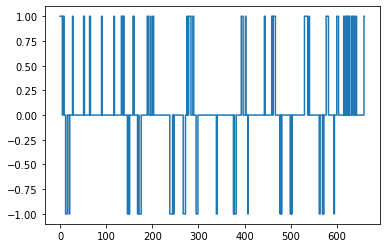

In [708]:
strategy = -1 + 1. * (ret_pred > 0.2) + 1. * (ret_pred > 0.8)
plt.step(np.arange(len(strategy)), strategy)

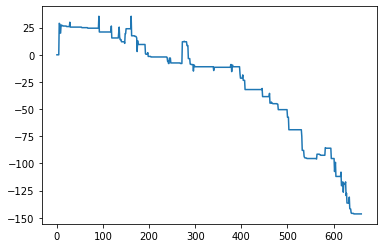

In [706]:
money = -np.maximum(np.diff(np.pad(strategy[:, 0], (1, 0)), axis=0), 0) * dfY['best_ask_price'].to_numpy()[WINDOW_SIZE-1:-1]
money += -np.minimum(np.diff(np.pad(strategy[:, 0], (1, 0)), axis=0), 0) * dfY['best_bid_price'].to_numpy()[WINDOW_SIZE-1:-1]
plt.plot(np.cumsum(money) + strategy[:, 0] * dfY['best_ask_price'].to_numpy()[WINDOW_SIZE:])